In [26]:
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [42]:
pwd = %pwd
data = SVHN(pwd, transform=lambda x: transforms.ToTensor()(x.convert('L')))

In [43]:
train_loader = DataLoader(dataset=data,
                               batch_size=100,# 这里定义了batch_size
                               shuffle=True,
                               num_workers=2)

In [44]:
# 迭代开始，然后，队列和线程跟着也开始
data_iter = iter(train_loader)

# mini-batch 图像 和 标签
images, labels = next(data_iter)

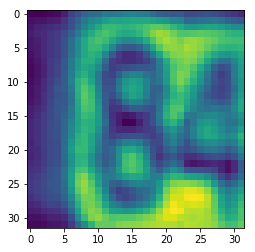

In [57]:
plt.imshow(images[0].numpy()[0])

In [5]:
import torch

torch.__version__

'0.3.1.post2'